En este proyecto vamos a mostrar cómo cargar y preprocesra un conjunto de datos de imagen de tres maneras:

* Primero, usamos utilidades de preprocesamiento de Keras de alto nivel(com tf.keras.utils.image_dataset_from_directory) y capas(como tf.keras.layers.Rescaling) para leer un directorio de imágenes en el disco.
* Escribimos nuestra propia canalización de entrada desde cero usando tf.data.
* Por último, descargamos un conjunto de datos del catálogo disponible en Tensorflow Datasets.

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

c:\Users\rodri\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Descargamos el conjunto de datos de flores.

El conjunto de datos contiene miles de fotos de flores. El conjunto de datos de flores contiene cinco subdirectorios:

daisy  
dandelion  
roses  
sunflowers  
tulips

In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin = dataset_url,
                                   fname = 'flower_photos',
                                   untar = True)

data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 10s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

Cada directorio contiene imágenes de ese tipo de flor. Veamos algunas rosas:

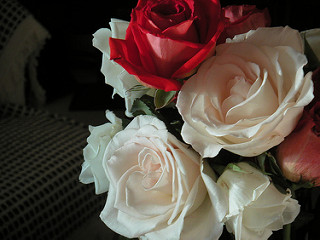

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

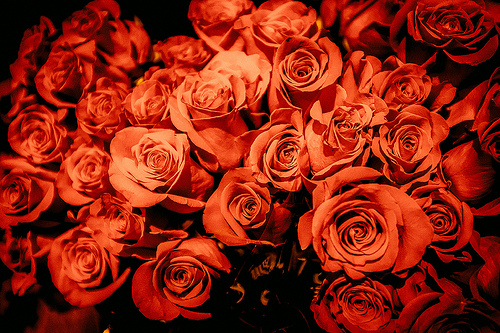

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[2]))

### Cargamos datos usando una utilidad Keras.

Cargamos estas imágenes fuera del disco utilizando la utilidad tf.keras.utils.image_dataset_from_directory

### Creamos un conjunto de datos.

Definimos algunos parámetros para el cargador.

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
"""

Es una buena práctica usar una división de validación al desarrollar un modelo.
Usamos el 80% de las imágenes para entrenamiento y el 20% para validación.

"""

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Veamos los nombres de clase del conjunto de datos.

In [11]:
class_name = train_ds.class_names
class_name

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Visualizamos los datos.

Veamos las primeras nueve imágenes del conjunto de datos de entrenamiento.

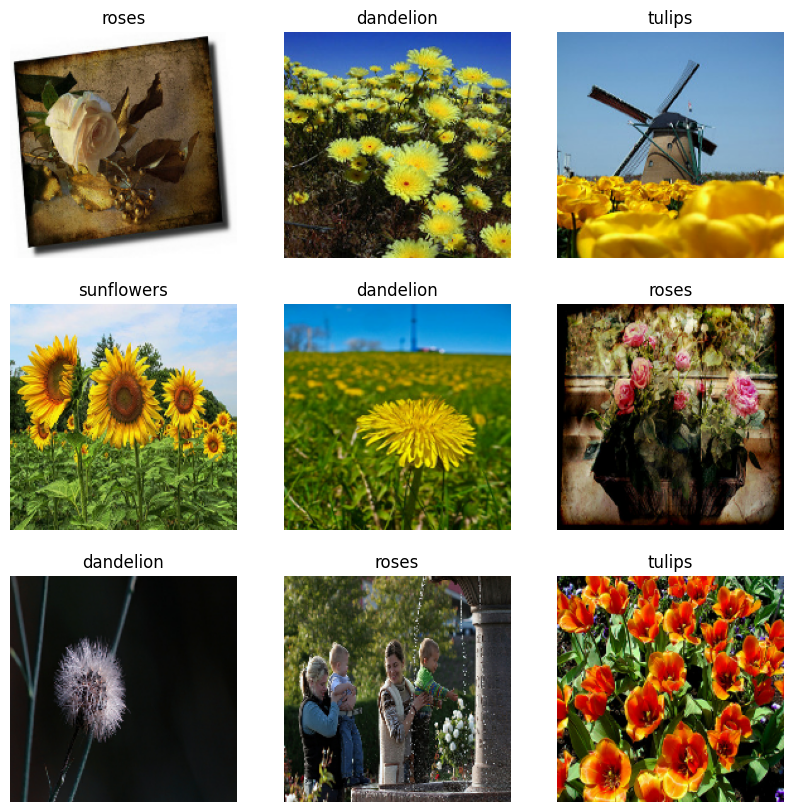

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_name[labels[i]])
        plt.axis('off')

Podemos entrenar un modelo usando estos conjuntos de datos pasándolos a model.fit. Pero también podemos iterar manualmente sobre el conjunto de datos y recuperar lotes de imágenes:

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


image_batch es un tensor de la forma(32, 180, 180, 3). Este es un lote de 32 imágenes de forma 180x180x3(la última dimensión se refiere a los canlaes de color RGB). El label_batch es un tensor de la forma(32,), estas son las etiquetas correspondientes a las 32 imágenes.

Podemos llamar a .numpy() en cualquiera de estos tensores para convertirlos en numpy.ndarray

### Estandarizar los datos.

Los valores del canal RGB están en el rango [0, 255]. Esto no es ideal para una red neuronal; en general, debemos buscar que sus valores de entradas sean pequeños.

Estandarizaremos los valores para que estén en el rango [0, 1] usando tf.keras.layers.Recaling:

In [14]:
norm_layer = tf.keras.layers.Rescaling(1./255)

Existen dos formas de usar esta capa. Podemos aplicarlo al conjunto de datos llamando a Dataset.map:

In [16]:
norm_ds = train_ds.map(lambda x, y: (norm_layer(x), y))
image_batch, labels_batch = next(iter(norm_ds))
first_image = image_batch[0]

# Veamos que los valores de píxeles ahora están en [0, 1].
print(np.min(first_image), '|', np.max(first_image))

0.0 | 0.99638706


O podemos incluir la capa dentro de la definición del modelo para simplificar la implementación.

_Nota_: Si te gustaría escalar los valores de píxeles a [-1, 1], usamos:
tf.keras.layers.Rescaling(1./127.5, offset = -1)

### Configurar el conjunto de datos para el rendimiento.

Asegurémonos de utilizar la captación previa almacenada en búfer para que podamos obtener datos del disco sin que la E/S se convierta en un bloqueo. Estos son dos métodos importantes que debemos usar al cargar datos:

* Dataset.cache mantiene las imágenes en la memoria después de que se cargan fuera del disco durante la primera época. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrena el modelo. Si el conjunto de datos es demasiado grande para caber en la memoria, también podemos usar este método para crear un caché en disco de alto rendimiento.

* Dataset.prefetch superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento.

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

### Entrenemos un modelo.

Para completar, mostramos cómo entrenamos un modelo simple utilizando los conjuntos de datos que acabamos de preparar.

El modelo Sequential consta de tres bloques de convolución(tf.keras.layers.Conv2D) con una capa de agrupación máxima(tf.keras.layers.MaxPooling2D) en cada uno. Hay una capa totalmente conectada(tf.keras.layers.Dense) con 128 unidades encima que se activa mediante una función de activación de ReLU('relu'). Este modelo no se ajustó de ninguna manera: el objetivo es ver la mecánica utilizando los conjuntos de datos que creamos.

In [18]:
num_classes = 5

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(num_classes)
])

Elegimos el optimizador tf.keras.optimizers.Adam y la función de pérdida tf.keras.losses.SparseCategoricalCrossentropy. Para ver la presición del entrenamiento y la validación para cada época de entrenamiento, pasamos el argumento de metrics a Model.compile.

In [19]:
model.compile(
    optimizer = 'adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

### Entrenamos el modelo.

Este solo entrenará durante pocas épocas.

In [20]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 3
)

Epoch 1/3
92/92 [==============================] - 144s 2s/step - loss: 1.2866 - accuracy: 0.4302 - val_loss: 1.1912 - val_accuracy: 0.5095
Epoch 2/3
92/92 [==============================] - 113s 1s/step - loss: 1.0286 - accuracy: 0.5950 - val_loss: 0.9910 - val_accuracy: 0.6035
Epoch 3/3
92/92 [==============================] - 127s 1s/step - loss: 0.8446 - accuracy: 0.6778 - val_loss: 0.8689 - val_accuracy: 0.6676


Vemos que la precisión de la validación es baja en comparación con la precisión del entrenamiento, lo que indica que el modelo se está sobreajustando.

### Uso de tf.data para un control más preciso.

La utilidad de preprocesamiento de Keras anterior, tf.keras.utils.image_dataset_from_directory, es una forma conveniente de crear un tf.data.Dataset a partir de un directorio de imágenes.

Para un control de grano más fino, podemos escribir nuestra propua canalización de entrada usando tf.data. Veamos cómo hacerlo, comenzando con las rutas de archivo del archivo TGZ que descargamos.

In [21]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle = False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration = False)

In [22]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\rodri\\.keras\\datasets\\flower_photos\\tulips\\7082476907_99beef0dde.jpg'
b'C:\\Users\\rodri\\.keras\\datasets\\flower_photos\\dandelion\\19617501581_606be5f716_n.jpg'
b'C:\\Users\\rodri\\.keras\\datasets\\flower_photos\\tulips\\14116826873_d4bab623bf_n.jpg'
b'C:\\Users\\rodri\\.keras\\datasets\\flower_photos\\tulips\\4418204816_018375acd0_m.jpg'
b'C:\\Users\\rodri\\.keras\\datasets\\flower_photos\\tulips\\3506615859_9850830cf0.jpg'


La estructura del árbol de los archivos se puede utilizar para compilar una lista de nombes de class_names.

In [24]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt']))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Dividamos el conjunto de datos en conjuntos de entrenamiento y validación.

In [25]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

Imprimimos la longitud de cada conjunto de datos de la siguiente manera:

In [26]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Escribimos una función breve que convierta una ruta de archivo en un par(img, label):

In [30]:
def get_label(file_path):
    # Convertimos el path a una lista de componentes de path.
    parts = tf.strings.split(file_path, os.path.sep)
    # El segundo al último es el directorio de clases.
    one_hot = parts[-2] == class_names
    # Codificación entera de la etiqueta.
    return tf.argmax(one_hot)

In [33]:
def decode_img(img):
    # Convertimos la cadena comprimida a un tensor uint8 3D
    img = tf.io.decode_jpeg(img, channels = 3)
    # Cambiamos el tamaño de la imagen al tamaño deseado
    return tf.image.resize(img, [img_height, img_width])

In [34]:
def process_path(file_path):
    label = get_label(file_path)
    # Cargarmos los datos sin procesar del archivo como una cadena.
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

Usamos Dataset.map para crear un conjunto de datos de pares de image, label:

In [35]:
# Configuramos 'num_parallel_calls' para que se carguen/procesen varias imágenes en paralelo.
train_ds = train_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls = AUTOTUNE)

In [37]:
for image, label in train_ds.take(1):
    print('Imagen shape:', image.numpy().shape)
    print('Label:', label.numpy())

Imagen shape: (180, 180, 3)
Label: 1


### Configurar el conjunto de datos para el rendimiento.

Para entrenar un modelo con este conjunto de datos, queremos los datos:

* Esten bien barajados.
* Para ser dosificado.
* Los lotes estarán disponibles lo antes posible.

Estas características se pueden agregar usando la API tf.data

In [38]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size = 1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

Visualicemos los datos de manera similar a como lo hicimos anteriormente.

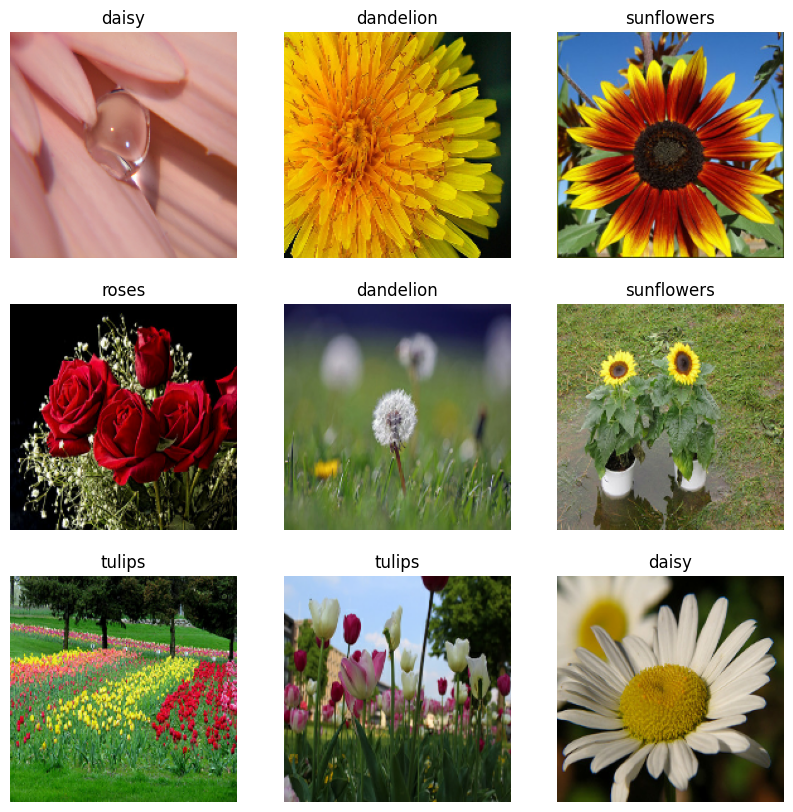

In [39]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize = (10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis('off')

### Entrenamos al modelo.

Acabamos de crear manualmente un tf.data.Dataset similar al creado por tf.keras.utils.image_dataset_from_directory. Podemos seguir entrenando el modelo con el este. Como antes, entrenamos el modelo durante pocas épocas.

In [40]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 3
)

Epoch 1/3
92/92 [==============================] - 127s 1s/step - loss: 0.7045 - accuracy: 0.7343 - val_loss: 0.6976 - val_accuracy: 0.7384
Epoch 2/3
92/92 [==============================] - 122s 1s/step - loss: 0.5241 - accuracy: 0.8113 - val_loss: 0.7056 - val_accuracy: 0.7425
Epoch 3/3
92/92 [==============================] - 115s 1s/step - loss: 0.3311 - accuracy: 0.8842 - val_loss: 0.7621 - val_accuracy: 0.7411


### Uso de conjuntos de datos de TensorFlow.

Hasta ahora, este proyecto se centró en cargar datos fuera del disco. También podemos encontrar un conjunto de datos para usar explorando el catálogo de conjuntos de datos de TensorFlow Datasets.

Como previamente cargamos el conjunto de datos Flowers fuera del disco, ahora importémoslo con TensorFlow Datasets.

Descargamos el conjunto de datos:

In [44]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info = True,
    as_supervised = True
)

El conjunto de datos de flores tiene cinco clases:

In [45]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Veamos una imagen del conjunto de datos:

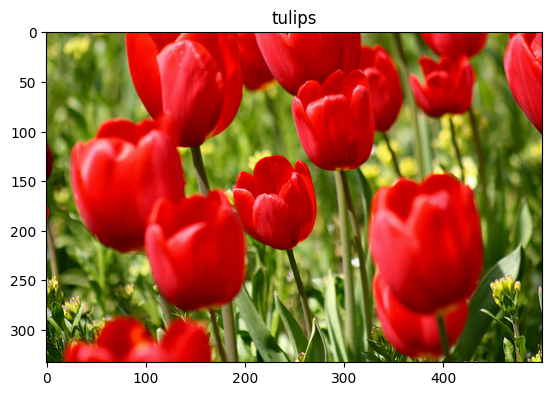

In [46]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Como antes, tenemos que agrupar, mezclar y configurar los conjuntos de entrenamiento, validación y prueba para el rendimiento:

In [47]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

En este proyecto vimos dos formas de cargar imágenes fuera del disco. En primer lugar, aprendimos a cargar y preprocesar un conjunto de datos de imagen utilizando las capas y utilidades de preprocesamiento de Keras. Luego, aprendimos a escribir una canalización de entrada desde cero utilizando tf.data. Por último, aprendimos a descargar un conjunto de datos de TensorFlow Datasets.